In [151]:
import pandas as pd
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import geopandas as gpd 
import os
import seaborn as sns
import sqlite3
from scipy.stats import ttest_ind
from add_functions import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import pickle

In [11]:
%matplotlib inline

## Gathering the data

In [12]:
# get US zipcodes with lat and long
us_zip_codes = pd.read_csv('/home/iborozan/work/Data-Science/projects/renewable/dataset/postal_codes/us/us-zip-code-latitude-and-longitude.csv', sep = ';')
zip_lat_lon = us_zip_codes[['Zip', "Latitude", "Longitude"]]

data_dir_openpv = '/home/iborozan/work/Data-Science/projects/renewable/dataset/openpv/'

# get the OpenPV data 
df_opv = pd.read_csv(data_dir_openpv + 'openpv_all.csv', sep=',')

/home/iborozan/anaconda3/envs/py_demo/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,5,8,12,13,14,15,16,20,23,25,26,27,28,32,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
# getting rid of columns with no data 

non_null_cols = [col for col in df_opv.columns if df_opv[col].notnull().sum() != 0]

df_opv = df_opv[non_null_cols]

df_opv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020674 entries, 0 to 1020673
Data columns (total 39 columns):
state                          1020674 non-null object
date_installed                 1020669 non-null object
incentive_prog_names           797958 non-null object
type                           1020669 non-null object
size_kw                        1020669 non-null float64
appraised                      224036 non-null object
zipcode                        1020669 non-null float64
install_type                   978093 non-null object
installer                      702607 non-null object
cost_per_watt                  763092 non-null float64
cost                           763253 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           799107 non-null object
utility_clean                  792720 non-null object
tech_1                         580919 non-null object
model1_clean 

## Start EDA 

In [14]:
df_opv['tracking'].value_counts()

# make all the other tracking fields to 0 'no tracking' is empty 

df_opv['tracking'].fillna(0, inplace=True)

# manufac entries same info drop columns 'manuf2_clean', 'manuf3_clean'
df_opv.loc[df_opv['manuf1_clean'].notnull(), ['manuf1_clean', 'manuf2_clean', 'manuf3_clean']].head()

df_opv = df_opv.drop(columns = ['manuf2_clean', 'manuf3_clean'])

# look at the year many values are missing drop it as well 
df_opv['year'].value_counts()

1/1/2007    27
1/1/2008     9
1/1/2006     7
1/1/2001     4
1/1/2002     4
1/1/2000     3
1/1/1999     3
1/1/2005     3
1999         3
1/1/2004     2
1/3/2000     1
1/2/2007     1
1/1/2003     1
Name: year, dtype: int64

In [15]:
df_opv = df_opv.drop(columns = ['year'])

# ditch all others since they indicate the same info 
df_opv['bipv_1'].value_counts()
df_opv['bipv_2'].value_counts()
df_opv['bipv_3'].value_counts()

# if building has an integrated pv or not 
df_opv['bipv'] = [1 if bipv == 1.0 else 0 for bipv in df_opv['bipv_1']]

df_opv = df_opv.drop(columns = ['bipv_1', 'bipv_2', 'bipv_3'])

In [16]:
df_opv.info()

# new_constr
df_opv['new_constr'].value_counts()

#fill these values wth zeros for no
df_opv['new_constr'].fillna(0, inplace=True)

# other fetaures with too little inforamtion drop them as well 
df_opv = df_opv.drop(columns = ['pbi_length', 'utility'])

df_opv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020674 entries, 0 to 1020673
Data columns (total 34 columns):
state                          1020674 non-null object
date_installed                 1020669 non-null object
incentive_prog_names           797958 non-null object
type                           1020669 non-null object
size_kw                        1020669 non-null float64
appraised                      224036 non-null object
zipcode                        1020669 non-null float64
install_type                   978093 non-null object
installer                      702607 non-null object
cost_per_watt                  763092 non-null float64
cost                           763253 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           799107 non-null object
utility_clean                  792720 non-null object
tech_1                         580919 non-null object
model1_clean 

In [17]:
# save it to a database 
#conn = sqlite3.Connection("/home/iborozan/work/Data-Science/projects/renewable/dataset/gosolar.db")
#conn.text_factory = str
#df_opv.to_sql('opv_clean', con=conn, if_exists='replace')

In [18]:
# read back from the database 
conn = sqlite3.Connection("/home/iborozan/work/Data-Science/projects/renewable/dataset/gosolar.db")
df_opv = pd.read_sql("SELECT * FROM opv_clean", con=conn)

# make sense to impute some of the nan values 
# annual_insolation, tilt1, azimuth make sense to use means here
# azimuth1: average azimuth (projected angle from north to sun) at solar installation.

median_tilt = df_opv.tilt1.median()
median_azimuth = df_opv.azimuth1.median()
median_annual_insolation = df_opv.annual_insolation.median()

df_opv.tilt1.fillna(median_tilt, inplace=True)
df_opv.azimuth1.fillna(median_azimuth, inplace=True)
df_opv.annual_insolation.fillna(median_annual_insolation, inplace=True)
# interested in residential only 
mask = ((df_opv['install_type'] == 'residential') | (df_opv['install_type'] == 'Residential')) & ((df_opv['size_kw'] > 0) & (~df_opv['annual_PV_prod'].isnull()) & (~df_opv['annual_insolation'].isnull()) & (~df_opv['azimuth1'].isnull() & (~df_opv['reported_annual_energy_prod'].isnull())))

df_opv_resid_us = df_opv[mask]

df_opv_resid_us['install_type'].value_counts()

residential    181564
Name: install_type, dtype: int64

In [19]:
# combaine these with latitude and longitude info  

df_opv_resid_us = df_opv_resid_us.merge(zip_lat_lon, left_on="zipcode", right_on="Zip")

In [20]:
# output these zipcodes for NREL querying
# df_opv_resid_us[['zipcode', 'Latitude', 'Longitude']].drop_duplicates(subset='zipcode', keep='first').to_csv('us_zip_codes_gosolar2.csv', index=False)
# upload the irradiance data downloaded from nrel 
conn = sqlite3.Connection("/home/iborozan/work/Data-Science/projects/renewable/dataset/NREL-US/gosolar.db")

zipcode_irradiance = pd.read_sql("SELECT * FROM zipcode_data", con=conn)

# save the database for future use
#conn2 = sqlite3.Connection("/home/iborozan/work/Data-Science/Insight/project/solar/solar/solar/models/nrel_data.db")
#zipcode_irradiance.to_sql('nrel_data', con=conn2, if_exists='replace')

### Consider only installations above 39 degree North based on the solar irradiance map from [NSRDB]( https://www.nrel.gov/gis/images/solar/solar_ghi_2018_usa_scale_01.jpg)

In [21]:
# before merging convert the column with zipcodes/postal codes to str 

zipcode_irradiance['zip_str'] = zipcode_irradiance['Zipcode'].apply(str)

df_opv_resid_us['zip_str'] = df_opv_resid_us['Zip'].apply(str)

df_opv_resid_us_irr = df_opv_resid_us.merge(zipcode_irradiance, on="zip_str", how='left')

# Now take only data points that are close to Canada/ON above the 39th parallel 
df_opv_resid_us_north = df_opv_resid_us_irr[df_opv_resid_us_irr['Latitude'] >= 39]

In [14]:
df_opv_resid_us_north.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97095 entries, 4271 to 172021
Data columns (total 45 columns):
index_x                        97095 non-null int64
state                          97095 non-null object
date_installed                 97095 non-null object
incentive_prog_names           97095 non-null object
type                           97095 non-null object
size_kw                        97095 non-null float64
appraised                      28301 non-null float64
zipcode                        97095 non-null float64
install_type                   97095 non-null object
installer                      57978 non-null object
cost_per_watt                  96909 non-null float64
cost                           96909 non-null float64
lbnl_tts_version_year          97095 non-null float64
lbnl_tts                       97095 non-null float64
city                           97095 non-null object
utility_clean                  96941 non-null object
tech_1                         67

In [15]:
# drop extra columns from mergining data that are not needed 

In [22]:
df_opv_resid_us_north = df_opv_resid_us_north.drop(columns = ['Zipcode', 'Zip', 'index_y', 'index_x'])

df_opv_resid_us_north.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97095 entries, 4271 to 172021
Data columns (total 41 columns):
state                          97095 non-null object
date_installed                 97095 non-null object
incentive_prog_names           97095 non-null object
type                           97095 non-null object
size_kw                        97095 non-null float64
appraised                      28301 non-null float64
zipcode                        97095 non-null float64
install_type                   97095 non-null object
installer                      57978 non-null object
cost_per_watt                  96909 non-null float64
cost                           96909 non-null float64
lbnl_tts_version_year          97095 non-null float64
lbnl_tts                       97095 non-null float64
city                           97095 non-null object
utility_clean                  96941 non-null object
tech_1                         67283 non-null object
model1_clean                   6

## Discover and Visualize the Data to Gain Insights 

### Detect outliers 

In [23]:
df_opv_resid_us_north['reported_annual_energy_prod_norm'] = df_opv_resid_us_north['reported_annual_energy_prod'] / df_opv_resid_us_north['size_kw']

# look at six standard deviation from the mean

reported_annual_energy_prod_norm_std = df_opv_resid_us_north.reported_annual_energy_prod_norm.std()
reported_annual_energy_prod_norm_mean = df_opv_resid_us_north.reported_annual_energy_prod_norm.mean()
mask_outliers = np.abs((reported_annual_energy_prod_norm_mean - df_opv_resid_us_north['reported_annual_energy_prod_norm'])/reported_annual_energy_prod_norm_std) < 6

# outliers are designated as False 
mask_outliers.value_counts()

True     97067
False       28
Name: reported_annual_energy_prod_norm, dtype: int64

### Plot outliers 

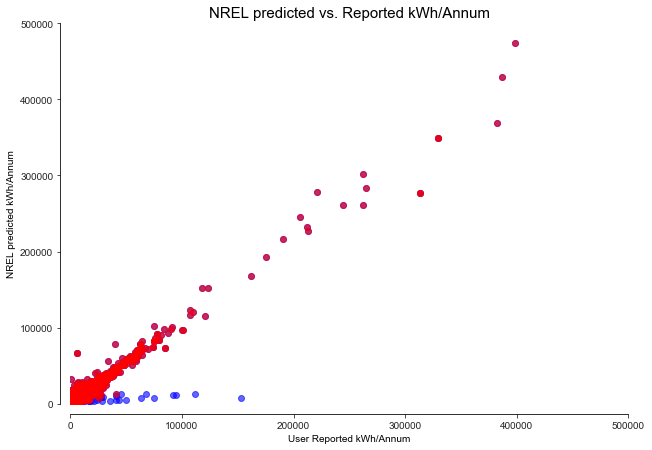

In [18]:
plt.figure(figsize=((10,7)))
plt.scatter(df_opv_resid_us_north['reported_annual_energy_prod'], df_opv_resid_us_north['annual_PV_prod'], alpha=0.6, c = 'blue')
# in read are the points that we keep 
plt.scatter(df_opv_resid_us_north['reported_annual_energy_prod'][mask_outliers], df_opv_resid_us_north['annual_PV_prod'][mask_outliers], alpha=0.6, c = 'red')
#sns.regplot(df_opv_resid_us_north['reported_annual_energy_prod'], df_opv_resid_us_north['annual_PV_prod'], ci=99.73)
plt.xlim(0,500000)
plt.ylim(0,500000)
plt.ylabel("NREL predicted kWh/Annum")
plt.xlabel("User Reported kWh/Annum")
plt.title("NREL predicted vs. Reported kWh/Annum", size=15)
sns.set_style("white")
sns.despine(offset=10, trim=False)

Some installtions on this plot (highlighted in blue) are clearly producing too much of the energy output for their size so I will not use them in my estimations 

In [24]:
#remove outlieres (in blue) from the dataset 
df_opv_resid_us_north_cleaned = df_opv_resid_us_north[mask_outliers]

In [20]:
# output this to a database for saving 
#conn = sqlite3.Connection("/home/iborozan/work/Data-Science/projects/renewable/dataset/gosolar.db")
#df_opv_resid_us_north_cleaned.to_sql('df_opv_resid_us_north_cleaned', con=conn, if_exists='replace')
# read it back from the db 
#df_opv_resid_us_north_cleaned = pd.read_sql("SELECT * FROM df_opv_resid_us_north_cleaned", con=conn)

In [21]:
# look at max and min dates of installation 
max(df_opv_resid_us_north_cleaned['date_installed'])

'12/31/2015'

In [22]:
min(df_opv_resid_us_north_cleaned['date_installed'])

'01/01/2006'

### Plot irradiance data as a function of the longitude

Text(31.875, 0.5, 'W/m2')

<Figure size 720x504 with 0 Axes>

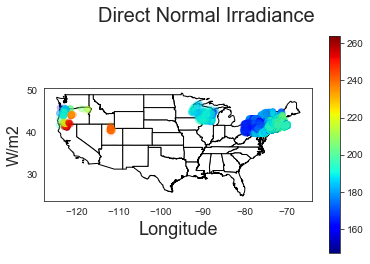

In [23]:
gdf = gpd.GeoDataFrame(df_opv_resid_us_north_cleaned, geometry=gpd.points_from_xy(df_opv_resid_us_north_cleaned.Longitude, df_opv_resid_us_north_cleaned.Latitude))

usa = gpd.read_file('/home/iborozan/work/Data-Science/projects/renewable/dataset/maps/us/states.shp')

#DNI
plt.figure(figsize=((10,7)))
ax = usa[(usa['STATE_NAME'] != 'Alaska') & (usa['STATE_NAME'] != 'Hawaii')].plot(color='white', edgecolor='black')
gdf.plot(ax=ax,  alpha=0.05,  column='DNI', cmap=plt.get_cmap("jet"), legend = True, label="DNI")
plt.suptitle('Direct Normal Irradiance', fontsize=20)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('W/m2', fontsize=16)
#save_fig("DNI_irradiance")

Text(31.875, 0.5, 'W/m2')

<Figure size 720x504 with 0 Axes>

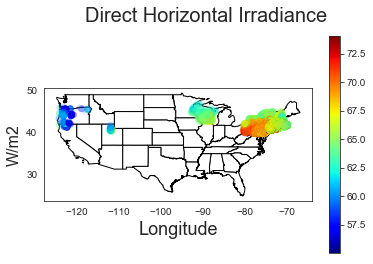

In [24]:
plt.figure(figsize=((10,7)))
ax = usa[(usa['STATE_NAME'] != 'Alaska') & (usa['STATE_NAME'] != 'Hawaii')].plot(color='white', edgecolor='black')
#gdf.plot(ax=ax, color='orange', alpha = 0.2)
#save_fig("Measured_energy_output")
gdf.plot(ax=ax,  alpha=0.05,  column='DHI', cmap=plt.get_cmap("jet"), legend = True, label="DHI")
plt.suptitle('Direct Horizontal Irradiance', fontsize=20)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('W/m2', fontsize=16)
#plt.show()

Text(31.875, 0.5, 'W/m2')

<Figure size 720x504 with 0 Axes>

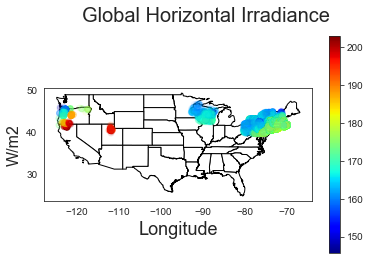

In [25]:
#GHI
plt.figure(figsize=((10,7)))
ax = usa[(usa['STATE_NAME'] != 'Alaska') & (usa['STATE_NAME'] != 'Hawaii')].plot(color='white', edgecolor='black')
#gdf.plot(ax=ax, color='orange', alpha = 0.2)
#save_fig("Measured_energy_output")
gdf.plot(ax=ax,  alpha=0.05,  column='GHI', cmap=plt.get_cmap("jet"), legend = True, label="GHI")
plt.suptitle('Global Horizontal Irradiance', fontsize=20)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('W/m2', fontsize=16)
#plt.show()

/home/iborozan/anaconda3/envs/py_demo/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/iborozan/anaconda3/envs/py_demo/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/iborozan/anaconda3/envs/py_demo/lib/python3.5/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

Text(0, 0.5, 'log(DNI)')

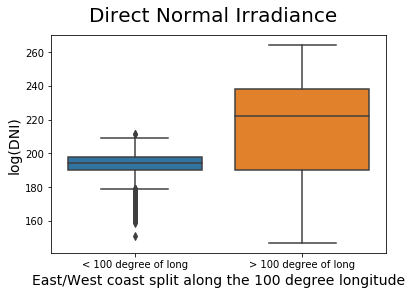

In [25]:
df_opv_resid_us_north_cleaned['longitude_split'] = '< 100 degree of long'
df_opv_resid_us_north_cleaned['longitude_split'][-df_opv_resid_us_north_cleaned['Longitude'] > 100] = '> 100 degree of long'


ax = sns.boxplot(x="longitude_split", y="DNI", data=df_opv_resid_us_north_cleaned)
#ax.set(yscale="log")
plt.suptitle('Direct Normal Irradiance', fontsize=20)
ax.set_xlabel("East/West coast split along the 100 degree longitude", 
                fontsize=14)
ax.set_ylabel("log(DNI)",
                fontsize=14)
#ax.tick_params(labelsize=10)
#plt.show()

### Found their is a significant difference in irradiance between the East and the West coasts

Text(0, 0.5, 'log(DHI)')

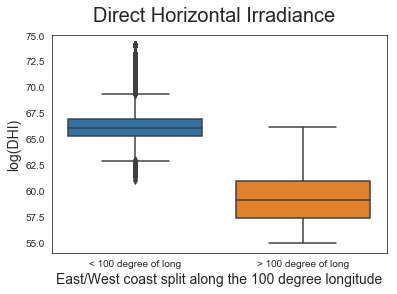

In [27]:
ax = sns.boxplot(x="longitude_split", y="DHI", data=df_opv_resid_us_north_cleaned)
#ax.set(yscale="log")
plt.suptitle('Direct Horizontal Irradiance', fontsize=20)
ax.set_xlabel("East/West coast split along the 100 degree longitude", 
                fontsize=14)
ax.set_ylabel("log(DHI)",
                fontsize=14)
#ax.tick_params(labelsize=10)
#plt.show()

Text(0, 0.5, 'log(GHI(W/m2))')

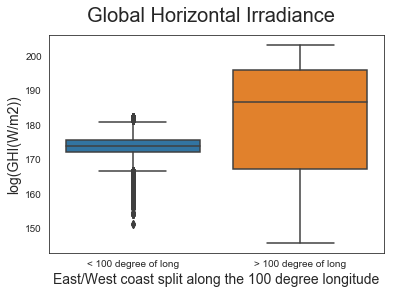

In [28]:
ax = sns.boxplot(x="longitude_split", y="GHI", data=df_opv_resid_us_north_cleaned)
#ax.set(yscale="log")
plt.suptitle('Global Horizontal Irradiance', fontsize=20)
ax.set_xlabel("East/West coast split along the 100 degree longitude", 
                fontsize=14)
ax.set_ylabel("log(GHI(W/m2))",
                fontsize=14)
#ax.tick_params(labelsize=10)
#plt.show()

In [29]:
# do a t-test to see if this diff is significant? 
# GHI
ghi1 = df_opv_resid_us_north_cleaned[df_opv_resid_us_north_cleaned['longitude_split'] == '< 100 degree of long']['GHI']
ghi2 = df_opv_resid_us_north_cleaned[df_opv_resid_us_north_cleaned['longitude_split'] == '> 100 degree of long']['GHI']

ttest_ind(ghi1[~ghi1.isnull()], ghi2[~ghi2.isnull()], equal_var = False)

Ttest_indResult(statistic=-15.31285350010687, pvalue=1.117957298486334e-47)

In [30]:
# DHI
dhi1 = df_opv_resid_us_north_cleaned[df_opv_resid_us_north_cleaned['longitude_split'] == '< 100 degree of long']['DHI']
dhi2 = df_opv_resid_us_north_cleaned[df_opv_resid_us_north_cleaned['longitude_split'] == '> 100 degree of long']['DHI']

ttest_ind(dhi1[~dhi1.isnull()], dhi2[~dhi2.isnull()], equal_var = False)

Ttest_indResult(statistic=102.39192699040787, pvalue=0.0)

In [31]:
# DNI
dni1 = df_opv_resid_us_north_cleaned[df_opv_resid_us_north_cleaned['longitude_split'] == '< 100 degree of long']['DNI']
dni2 = df_opv_resid_us_north_cleaned[df_opv_resid_us_north_cleaned['longitude_split'] == '> 100 degree of long']['DNI']

ttest_ind(dni1[~dni1.isnull()], dni2[~dni2.isnull()], equal_var = False)

Ttest_indResult(statistic=-28.28223368548881, pvalue=1.3933211037572761e-129)

In [180]:
# To predict the energy output in Canada I decided to keep only datapoints east of the 100 degree longitude 

df_opv_resid_us_north_cleaned_east  = df_opv_resid_us_north_cleaned[df_opv_resid_us_north_cleaned['longitude_split'] == '< 100 degree of long']


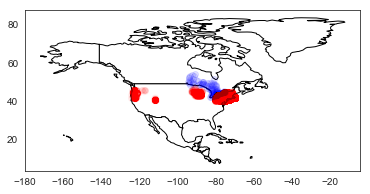

In [179]:
on_communities = pd.read_csv('/home/iborozan/work/Data-Science/projects/renewable/dataset/retired/communities-ON/geonames.csv', sep = ',')

#df_plot_geo = pd.DataFrame(np.zeros((on_communities.shape[0], df_opv_resid_us_north_cleaned_east.shape[1])))
df_plot_geo = pd.DataFrame(np.zeros((on_communities.shape[0], df_opv_resid_us_north_cleaned.shape[1])))
#df_plot_geo.columns = df_opv_resid_us_north_cleaned_east.columns
df_plot_geo.columns = df_opv_resid_us_north_cleaned.columns
df_plot_geo['Latitude'] = on_communities.latitude
df_plot_geo['Longitude'] = on_communities.longitude

#df_plot = pd.concat([df_plot_geo, df_opv_resid_us_north_cleaned_east])

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black')

gdf_ca = gpd.GeoDataFrame(df_plot_geo, geometry=gpd.points_from_xy(df_plot_geo.Longitude, df_plot_geo.Latitude))
#gdf_usa = gpd.GeoDataFrame(df_opv_resid_us_north_cleaned_east, geometry=gpd.points_from_xy(df_opv_resid_us_north_cleaned_east.Longitude, df_opv_resid_us_north_cleaned_east.Latitude))
gdf_usa = gpd.GeoDataFrame(df_opv_resid_us_north_cleaned, geometry=gpd.points_from_xy(df_opv_resid_us_north_cleaned.Longitude, df_opv_resid_us_north_cleaned.Latitude))
gdf_ca.plot(ax=ax, alpha=0.1,  c = 'blue')
gdf_usa.plot(ax=ax, alpha=0.01,  c = 'red')
#save_fig("Ontaro_communities")
#plt.show()

### To predict the energy output in Ontario I decided to keep only datapoints east from 100 degree longitude 

Saving figure /home/iborozan/work/Data-Science/Insight/project/presentations/week4/Ontaro_communities.png


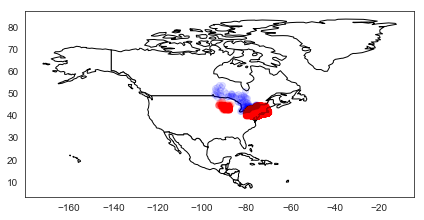

In [181]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """A function for saving figures in a prespecified direcotry"""
    IMAGES_PATH = '/home/iborozan/work/Data-Science/Insight/project/presentations/week4/'
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", path)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



# now plot the data but without west cost data 
df_plot_geo = pd.DataFrame(np.zeros((on_communities.shape[0], df_opv_resid_us_north_cleaned_east.shape[1])))
#df_plot_geo = pd.DataFrame(np.zeros((on_communities.shape[0], df_opv_resid_us_north_cleaned.shape[1])))
df_plot_geo.columns = df_opv_resid_us_north_cleaned_east.columns
#df_plot_geo.columns = df_opv_resid_us_north_cleaned.columns
df_plot_geo['Latitude'] = on_communities.latitude
df_plot_geo['Longitude'] = on_communities.longitude

#df_plot = pd.concat([df_plot_geo, df_opv_resid_us_north_cleaned_east])


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black')

gdf_ca = gpd.GeoDataFrame(df_plot_geo, geometry=gpd.points_from_xy(df_plot_geo.Longitude, df_plot_geo.Latitude))
gdf_usa = gpd.GeoDataFrame(df_opv_resid_us_north_cleaned_east, geometry=gpd.points_from_xy(df_opv_resid_us_north_cleaned_east.Longitude, df_opv_resid_us_north_cleaned_east.Latitude))
#gdf_usa = gpd.GeoDataFrame(df_opv_resid_us_north_cleaned, geometry=gpd.points_from_xy(df_opv_resid_us_north_cleaned.Longitude, df_opv_resid_us_north_cleaned.Latitude))
gdf_ca.plot(ax=ax, alpha=0.1,  c = 'blue')
gdf_usa.plot(ax=ax, alpha=0.01,  c = 'red')
save_fig("Ontaro_communities")
#plt.show()    

### Compare baseline data from NREL to real data reported from installations on the ground

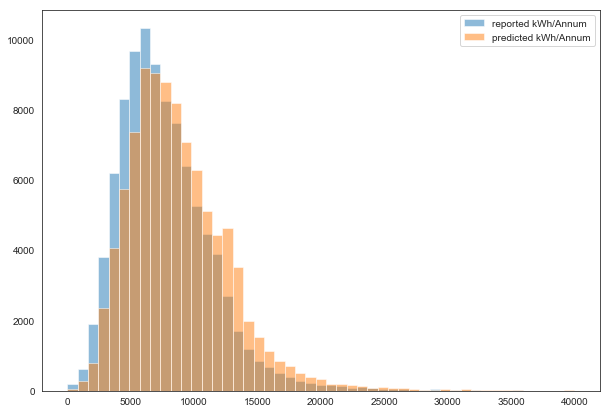

In [34]:
# Plot the two histograms of the baseline and the reported energy produced 
plt.figure(figsize=((10,7)))
bins = np.linspace(0, 40000, 50)
plt.hist(list(df_opv_resid_us_north_cleaned_east['reported_annual_energy_prod']), bins, label='reported kWh/Annum', alpha=0.5)
plt.hist(list(df_opv_resid_us_north_cleaned_east['annual_PV_prod']), bins, label='predicted kWh/Annum', alpha=0.5)
plt.legend(loc='upper right')
#save_fig('histogram_energy_predicted_real')
#plt.show()

In [28]:
# feature engeneering and feature selection 

# A zero tilt angle means that the face of the panel is aimed directly overhead. A positive tilt angle means that the panel faces more towards the equator. In the northern hemisphere that would mean tilting so it faces towards the South. Rarely, the tilt angle can be negative; this means the panel faces away from the equator.

# To optimize overall production year-round, tilt your panels at your latitude 

df_opv_resid_us_north_cleaned_east['tilt_difference'] = np.abs(df_opv_resid_us_north_cleaned_east['tilt1'] - df_opv_resid_us_north_cleaned_east['Latitude'])

# have tracking as a categorical variable
df_opv_resid_us_north_cleaned_east.loc[:, 'tracking_cat'] = df_opv_resid_us_north_cleaned_east['tracking']
df_opv_resid_us_north_cleaned_east.loc[df_opv_resid_us_north_cleaned_east['tracking'] == 0, 'tracking_cat'] = 'No'
df_opv_resid_us_north_cleaned_east.loc[df_opv_resid_us_north_cleaned_east['tracking'] == 1, 'tracking_cat'] = 'Yes'

# further data cleaning for the tech1 feature

df_opv_resid_us_north_cleaned_east.loc[df_opv_resid_us_north_cleaned_east['tech_1'].isnull(), 'tech_1'] = 'unknown_tech' 

df_opv_resid_us_north_cleaned_east['tech_1'].value_counts()

# fill the cost for missing values 
median_cost = df_opv_resid_us_north_cleaned_east['cost'].median()

df_opv_resid_us_north_cleaned_east['cost'].fillna(median_cost, inplace=True)

/home/iborozan/anaconda3/envs/py_demo/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/iborozan/anaconda3/envs/py_demo/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/iborozan/anaconda3/envs/py_demo/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

#### Examine azimuth values from the existing installations on the ground  

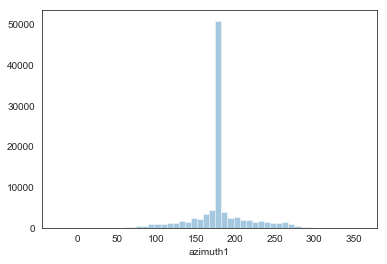

In [36]:
# Examine azimuth values from existing installations 
# azimuth1: average azimuth (projected angle from north to the sun) at solar installation.
# inlcude the picture from https://www.wholesalesolar.com/blog/solar-panel-azimuth-angle/
sns.distplot(df_opv_resid_us_north_cleaned_east['azimuth1'], kde=False, rug=False);
plt.show()
#plt.hist(list(df_opv_resid_us_north_cleaned_east['azimuth1']))

## Prepare the Data for Machine Learning Algorithms 

### Split the data into test and training sets and put the test set away 

In [29]:
train_set, test_set = train_test_split(df_opv_resid_us_north_cleaned_east, test_size=0.2, random_state=42)

In [30]:
# seperate features into numerical and categorical variables 
num_attribs = ['size_kw', 'azimuth1', 'tilt_difference', 'DHI', 'DNI', 'GHI', 'Temperature', 'Wind Speed']
cat_attribs = ['tech_1', 'tracking_cat']

In [31]:
# look at the summary of the numerical attributes/features 
train_set[num_attribs].describe()

,size_kw,azimuth1,tilt_difference,DHI,DNI,GHI,Temperature,Wind Speed
count,76859.000000,76859.000000,76859.000000,76798.000000,76798.000000,76798.000000,76798.000000,76798.000000
mean,7.227492,180.938992,16.137492,66.319676,192.542212,173.229619,9.601923,1.299214
std,13.917784,34.826534,6.807458,1.595813,8.181903,3.887521,1.234607,1.452467
min,0.150000,-26.000000,0.002547,61.067009,150.821575,151.177283,2.899429,0.127158
25%,4.830000,178.000000,11.526256,65.336416,190.164041,171.989384,8.865525,0.288573
50%,6.500000,180.000000,18.752098,66.079338,194.421689,173.857763,9.476941,0.633231
75%,8.829000,180.000000,20.449454,66.951712,197.964384,175.615868,10.568037,1.942283
max,2611.080000,360.000000,48.292068,74.048973,211.397717,182.213699,11.910731,5.740091


In [168]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """A function for saving figures in a prespecified direcotry"""
    IMAGES_PATH = '---'
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    #print("Saving figure", path)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


def corr_heat_map(df, title, size):
    """
    This function plots a correlation heatmap for a dataframe 
    """
    corrs = df.corr()
    
    # set figure size
    fig, ax = plt.subplots(figsize = size)
    
    # generate a mask for the upper triagle 
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    #plot heatmap
    ax = sns.heatmap(corrs, mask=mask, annot = True, cbar=True)
    
    #resize labels
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12, rotation=45)
    ax.set_title(title, fontsize=14)
    fig.tight_layout()
    #https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
    plt.subplots_adjust(bottom = 0.33)
    #save_fig("heatmap_corr")
    #plt.show()

### Plot the correlation matrix for numerical attributes

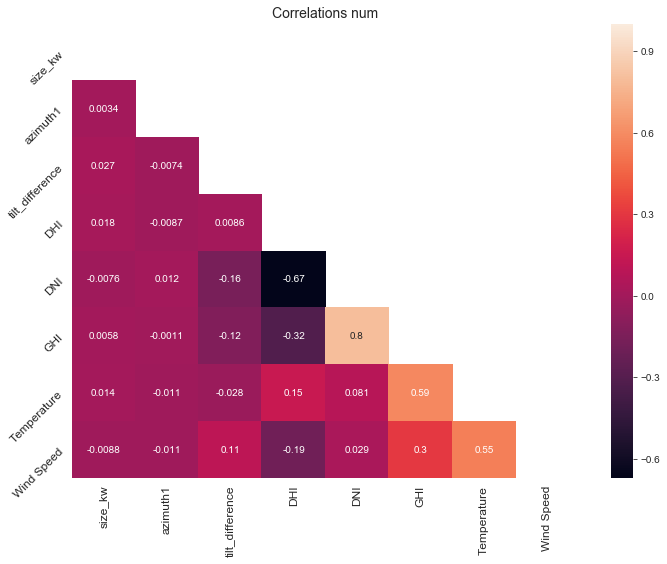

In [169]:
corr_heat_map(train_set[num_attribs], 'Correlations num', (10,10))

In [40]:
# examine the two categorical features 
train_set['tech_1'].value_counts()

Poly            30078
unknown_tech    23460
Mono            20214
crystalline      2461
Mono + a-Si       575
CIGS               42
a-Si               27
multiple            2
Name: tech_1, dtype: int64

### Do some further data cleaning 

In [41]:
train_set['tracking'].value_counts()

0.0    76611
1.0      248
Name: tracking, dtype: int64

In [42]:
# most of the inatllations have no tracking feature so we will not keep this feature for downstream analysis
cat_attribes = ['tech_1']

### Define transformation pipelines

In [34]:
# for missing numerical data we will apply the median using SimpleImputer
# pipeline for processing numerical data 
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [44]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        # without cat variables  
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [91]:
# transform the training set 
X_train_tr = full_pipeline.fit_transform(train_set)
# get the labels for the training set 
y_train = train_set['reported_annual_energy_prod']

In [92]:
# transform the test 
X_test = test_set[num_attribs + cat_attribs]
y_test = test_set['reported_annual_energy_prod'].copy()
X_test_tr = full_pipeline.transform(X_test)

### Baseline model performance 

In [91]:
# R2 metric 
y_pred = test_set['annual_PV_prod']
y_true = test_set['reported_annual_energy_prod']

r2_score(y_true, y_pred)

0.8701808994965667

In [127]:
# get rmse using the baseline  
base_mse_test = mean_squared_error(test_set['reported_annual_energy_prod'], test_set['annual_PV_prod'])
base_rmse_test = np.sqrt(base_mse_test)
base_rmse_test

1865.3331654792764

In [93]:
base_rmse_test*0.134

249.95464417422306

In [107]:
# dollar value 
abs_residuals = np.abs(np.array(y_true) - np.array(y_pred))
# avg can rate per kilowat/hour is $.134
residuals_dollars = abs_residuals * 0.134
np.median(residuals_dollars)
# this will be our reference point for how much saving we can generate using other more compexe models 

109.12121186800002

### Linear Regression Model 

In [108]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_tr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [110]:
# Examine the linear model performance 
test_set_pred_lin = lin_reg.predict(X_test_tr)
lin_mse_test = mean_squared_error(y_test, test_set_pred_lin)
lin_rmse_test = np.sqrt(lin_mse_test)
# get rmse using the linear regression model   
lin_rmse_test 

1406.5656314733562

In [94]:
lin_rmse_test*0.134

190.31638868248604

In [115]:
#linear model dollar value 
abs_residuals_lin = np.abs(np.array(test_set['reported_annual_energy_prod']) - np.array(test_set_pred_lin))
# avg ontario rate per kilowatt hour is $0.134
residuals_dollars_lin = abs_residuals_lin * 0.134
np.median(residuals_dollars_lin)

60.25322033764584

In [114]:
r2_score(y_test, test_set_pred_lin)

0.9261848044515588

### Random Forest Regression  

#### Grid Search and hyperparameter tuning 

In [117]:
param_grid = [
    # try 9 (3×3) combinations of hyperparameters
    {'n_estimators': [10, 100, 200], 'max_features': [2, 3, 4]}
  ]

forest_reg = RandomForestRegressor(random_state=42)

In [118]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train_tr, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_features': [2, 3, 4], 'n_estimators': [10, 100, 200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [121]:
feature_importances_rf = grid_search.best_estimator_.feature_importances_

In [122]:
feature_importances_rf

array([8.78326079e-01, 3.79556759e-03, 4.39463263e-02, 4.13381621e-03,
       2.36333125e-02, 1.05980180e-02, 4.80680526e-03, 4.27826808e-03,
       1.13089499e-05, 1.94144320e-03, 2.32327114e-05, 3.23902977e-04,
       1.00510972e-06, 3.22795734e-03, 9.20803278e-08, 2.08770846e-02,
       3.38896610e-05, 4.18905288e-05])

In [125]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
feature_importances_rf_sorted = sorted(zip(feature_importances_rf, attributes), reverse=True)

In [126]:
feature_importances_rf_sorted

[(0.8783260788320855, 'size_kw'),
 (0.04394632632713284, 'tilt_difference'),
 (0.023633312542622305, 'DNI'),
 (0.020877084558666, 'unknown_tech'),
 (0.010598018032037162, 'GHI'),
 (0.004806805262099367, 'Temperature'),
 (0.004278268084379397, 'Wind Speed'),
 (0.004133816214481891, 'DHI'),
 (0.0037955675919797314, 'azimuth1'),
 (0.003227957336331494, 'crystalline'),
 (0.0019414431999164432, 'Mono'),
 (0.00032390297712928714, 'Poly'),
 (2.3232711440484816e-05, 'Mono + a-Si'),
 (1.1308949860356635e-05, 'CIGS'),
 (1.0051097238700173e-06, 'a-Si'),
 (9.208032783006543e-08, 'multiple')]

Since 'unknown_tech' is one of the levels for the categorical variable tech_1 that is not well defined we will retrain the models by only using numerical variables

## Further feature selection & retrain  

### Removing categorical variables from the model and retraining 

In [35]:
# for missing numerical data we will apply the median using SimpleImputer
# pipeline for processing numerical data 
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [36]:
# exclude categorical variables from the model 
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        # without cat variables  
        #("cat", OneHotEncoder(), cat_attribs),
    ])

In [37]:
# transform the training set 
X_train_tr = full_pipeline.fit_transform(train_set)
# get the labels for the training set 
y_train = train_set['reported_annual_energy_prod']

In [38]:
# transform the test 
X_test = test_set[num_attribs + cat_attribs]
y_test = test_set['reported_annual_energy_prod'].copy()
X_test_tr = full_pipeline.transform(X_test)

In [1]:
# save both the training and test sets:
#filename = 'X_train_tr.savib'
#pickle.dump(X_train_tr, open(filename, 'wb'))

#filename = 'y_train.savib'
#pickle.dump(y_train, open(filename, 'wb'))

#filename = 'X_test_tr.savib'
#pickle.dump(X_test_tr, open(filename, 'wb'))

#filename = 'y_test.savib'
#pickle.dump(y_test, open(filename, 'wb'))

## Linear Regression Model 

In [98]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_tr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### RMSE

In [99]:
# Examine the linear model performance 
test_set_pred_lin = lin_reg.predict(X_test_tr)
lin_mse_test = mean_squared_error(y_test, test_set_pred_lin)
lin_rmse_test = np.sqrt(lin_mse_test)
# get rmse using the linear regression model   
lin_rmse_test 

1420.2715573319852

In [100]:
lin_rmse_test*0.134

190.31638868248604

### R2

In [97]:
r2_score(y_test, test_set_pred_lin)

0.9247392483675102

### Dollar value

In [130]:
#linear model dollar value 
abs_residuals_lin = np.abs(np.array(test_set['reported_annual_energy_prod']) - np.array(test_set_pred_lin))
# avg ontario rate per kilowatt hour is $0.134
residuals_dollars_lin = abs_residuals_lin * 0.134
np.median(residuals_dollars_lin)

65.92884955471476

## Random Forest Regression  

Grid Search and hyperparameter tuning 

In [50]:
param_grid = [
    # try 9 (3×3) combinations of hyperparameters
    {'n_estimators': [10, 100, 200], 'max_features': [2, 3, 4]}
  ]

forest_reg = RandomForestRegressor(random_state=42)

In [51]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train_tr, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [10, 100, 200], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [55]:
feature_importances_rf = grid_search.best_estimator_.feature_importances_

In [56]:
feature_importances_rf

array([0.87744905, 0.00267352, 0.09195018, 0.00451233, 0.00314039,
       0.00182859, 0.01358847, 0.00485747])

In [57]:
feature_importance = pd.DataFrame({
    #'feature': attributes,
    #'importance': grid_search.best_estimator_.feature_importances_[0:len(attributes)]
    'feature': num_attribs,
    'importance': grid_search.best_estimator_.feature_importances_
})

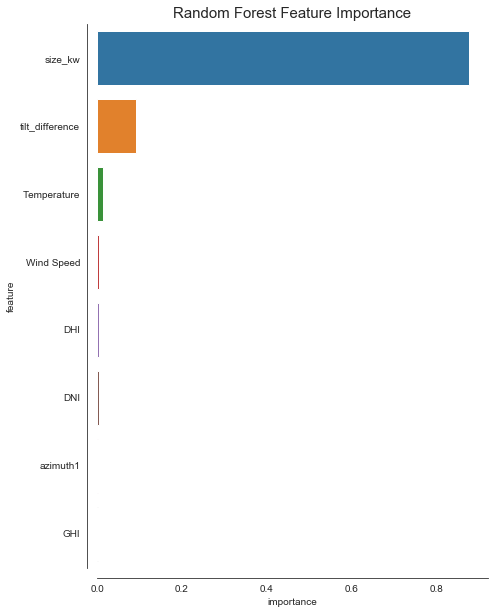

In [170]:
feature_importance.sort_values("importance", inplace=True, ascending=False)

plt.figure(figsize=(7,10))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature, orient='h')
plt.title("Random Forest Feature Importance", size=15)
sns.set_style("white")
sns.despine(offset=10, trim=False);
#save_fig("RF_Feature_Importance")
#plt.show()

In [59]:
final_model_rf = grid_search.best_estimator_

test_set_predictions_rf = final_model_rf.predict(X_test_tr)

### RMSE

In [60]:
final_mse_rf = mean_squared_error(y_test, test_set_predictions_rf)
final_rmse_rf = np.sqrt(final_mse_rf)
final_rmse_rf

1311.4528567995355

In [71]:
final_rmse_rf*0.134

175.73468281113776

### R2

In [70]:
r2_score(y_test, test_set_predictions_rf)

0.9358301330853965

### Dollar Value

In [129]:
abs_residuals_rf = np.abs(np.array(test_set['reported_annual_energy_prod']) - np.array(test_set_predictions_rf))
# avg can rate per kilowatt hour is $.134
residuals_dollars_rf = abs_residuals_rf * 0.134
np.median(residuals_dollars_rf)


40.743504000000065

## Gradient Boosting Regression 

In [63]:
param_grid_gbrt = [
    # try 12 (4x3) combinations of hyperparameters
    {'n_estimators': [10, 100, 200, 300], 'learning_rate': [0.1, 0.2, 0.3], 'max_features': [2, 3, 4]}
]

gbrt = GradientBoostingRegressor(random_state=42)

In [64]:
grid_search_gbrt = GridSearchCV(gbrt, param_grid_gbrt, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search_gbrt.fit(X_train_tr, y_train)

feature_importances_gbrt = grid_search_gbrt.best_estimator_.feature_importances_

In [72]:
final_model_gbrt  = grid_search_gbrt.best_estimator_

test_set_predictions_gbrt = final_model_gbrt.predict(X_test_tr)

### RMSE

In [73]:
final_mse_gbrt = mean_squared_error(y_test, test_set_predictions_gbrt)
final_rmse_gbrt = np.sqrt(final_mse_gbrt)
final_rmse_gbrt

1249.2762993430233

In [101]:
final_rmse_gbrt*0.134

167.40302411196512

### R2

In [74]:
r2_score(y_test, test_set_predictions_gbrt)

0.9417705385732612

### Dollar value  

In [123]:
abs_residuals_gbrt = np.abs(np.array(test_set['reported_annual_energy_prod']) - np.array(test_set_predictions_gbrt))
# avg us rate per kilowatt hour is $.1024
residuals_dollars_gbrt = abs_residuals_gbrt * 0.134
np.median(residuals_dollars_gbrt)

43.01404329241572

## XGBoost

In [39]:
import xgboost as xgb
from xgboost import XGBRegressor

In [40]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [110]:
params_grid_xgb = {
        #'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        #'subsample': [0.6, 0.8, 1.0],
        #'colsample_bytree': [0.3, 0.6, 0.8],
        #'max_depth': [2, 3, 4],
        #'n_estimators': [100, 200, 300, 400],
        #'learning_rate': [0.01, 0.05, 0.1]
        'min_child_weight': [1, 2],
        #'gamma': [0.5, 1],
        #'subsample': [0.6, 0.8],
        #'colsample_bytree': [0.3, 0.6],
        'max_depth': [3, 4],
        'n_estimators': [300, 400],
        'learning_rate': [0.02, 0.05, 0.1]
        }

In [111]:
xgb = XGBRegressor(objective='reg:linear', seed=42)

In [112]:
grid_search_xgb = GridSearchCV(xgb, params_grid_xgb, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)

In [113]:
# look for the parameters you can hypertune 
# grid_search_xgb.estimator.get_params().keys()

In [114]:
from datetime import datetime
start_time = timer(None) # timing starts from this point for "start_time" variable
grid_search_xgb.fit(X_train_tr, y_train)
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 11 minutes and 10.99 seconds.


In [116]:
feature_importances_xgb = grid_search_xgb.best_estimator_.feature_importances_

final_model_xgb = grid_search_xgb.best_estimator_

In [117]:
final_model_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [118]:
test_set_predictions_xgb = final_model_xgb.predict(X_test_tr)

final_mse_xgb = mean_squared_error(y_test, test_set_predictions_xgb)
final_rmse_xgb = np.sqrt(final_mse_xgb)
final_rmse_xgb

1150.0530619211152

In [121]:
final_rmse_xgb*0.134

154.10711029742944

In [125]:
r2_score(y_test, test_set_predictions_xgb)

0.9506529121153624

In [126]:
abs_residuals_xgb = np.abs(np.array(y_test) - np.array(test_set_predictions_xgb))
# avg us rate per kilowatt hour is $.1024
residuals_dollars_xgb = abs_residuals_xgb * 0.134
np.median(residuals_dollars_xgb)

42.2559054687501

# Modeling the cost 

In [131]:
# conversion rate between the US to Canadian 
converison_rate = 1.33
data_cost = df_opv_resid_us_north_cleaned_east.loc[df_opv_resid_us_north_cleaned_east['size_kw'] < 50, ['cost', 'size_kw']]

data_cost['cost_can'] = data_cost['cost']*converison_rate

cost_kw = (data_cost['cost']*converison_rate)/data_cost['size_kw']

cost_kw_std = cost_kw.std()
cost_kw_mean = cost_kw.mean()
mask_outliers_cost = np.abs((cost_kw_mean - cost_kw)/cost_kw_std) <= 2
mask_outliers_cost.value_counts()

True     92805
False     3192
dtype: int64

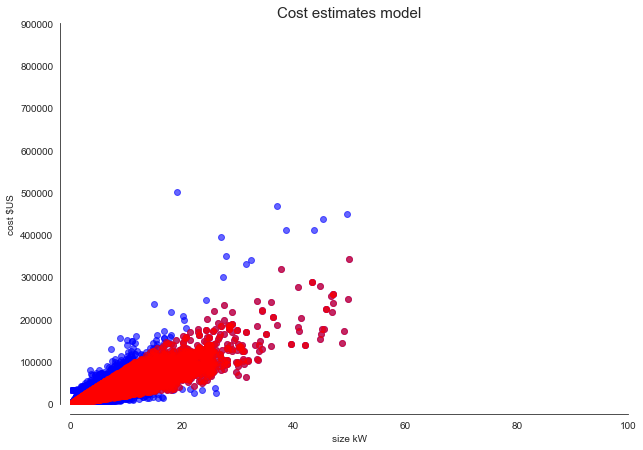

In [132]:
plt.figure(figsize=((10,7)))
plt.scatter(data_cost['size_kw'], data_cost['cost'], alpha=0.6, c = 'blue')
plt.scatter(data_cost['size_kw'][mask_outliers_cost], data_cost['cost'][mask_outliers_cost], alpha=0.6, c = 'red')
#sns.regplot(df_opv_resid_us_north['reported_annual_energy_prod'], df_opv_resid_us_north['annual_PV_prod'], ci=99.73)
plt.xlim(0,100)
plt.ylim(0,900000)
plt.ylabel("cost $US")
plt.xlabel("size kW")
plt.title("Cost estimates model", size=15)
sns.set_style("white")
sns.despine(offset=10, trim=False)
#save_fig("energy_predicted_vs_measured")
#plt.show()

In [133]:
train_set_cost, test_set_cost = train_test_split(data_cost[mask_outliers_cost], test_size=0.2, random_state=42)

train_set_cost_prepared = array(train_set_cost['size_kw']).reshape(-1,1)
train_set_labels_cost = train_set_cost['cost_can']

X_test_cost = array(test_set_cost['size_kw']).reshape(-1,1)
y_test_cost = test_set_cost['cost_can'].copy()
y_test_cost = y_test_cost

# use a simple linear regression model  
lin_reg_cost = LinearRegression()
lin_reg_cost.fit(train_set_cost_prepared, train_set_labels_cost)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [134]:
test_set_predictions = lin_reg_cost.predict(X_test_cost)
lin_mse_test_cost = mean_squared_error(y_test_cost, test_set_predictions)
lin_rmse_test_cost = np.sqrt(lin_mse_test_cost)
r2_score(y_test_cost, test_set_predictions)


0.7304447068345781

In [135]:
stdev = np.sqrt(sum((y_test_cost - test_set_predictions)**2) / (len(test_set_predictions) - 2))

In [136]:
# estimated stadard deviation 
stdev 

11462.002315678359

In [137]:
abs_residuals_cost = np.abs(np.array(y_test_cost) - np.array(test_set_predictions))
# avg us rate per kilowatt hour is $.1024
residuals_dollars_cost = abs_residuals_cost
np.median(residuals_dollars_cost)

6650.858298340845

Associated error in terms of the cost 

In [147]:
np.median(np.array(test_set_predictions))

43530.740986241246

In [148]:
np.median(residuals_dollars_cost)/np.median(np.array(test_set_predictions))

0.15278532245621504

### Save the best model and transformation piplines for production and the webapp

In [171]:
#filename = 'finalized_lin_model_cost.sav'
#pickle.dump(lin_reg_cost, open(filename, 'wb'))

#filename = 'finalized_gbrt_model.sav'
#pickle.dump(grid_search_gbrt, open(filename, 'wb'))

#filename = 'full_pipeline.sav'
#pickle.dump(full_pipeline, open(filename, 'wb'))

#check that my projection are in line with the data 
#train_set[train_set['size_kw'] == 4]['reported_annual_energy_prod'].mean()